# Energy Production Dataset Time Series RNN

Dataset is the monthly energy index from January 1970 to December 1989. 

Reference material: https://github.com/NVDLI/LDL/blob/523de08157db6312b67f80e45fc4ba82ab89e372/tf_framework/c9e1_rnn_book_sales.ipynb

In [ ]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

### Importing Libraries and Reading the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
import logging
tf.get_logger().setLevel(logging.ERROR)

EPOCHS = 100
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = 'EnergyProduction.csv'

def readfile(file_name):
    file = open(file_name, 'r', encoding='utf-8')
    next(file)
    data = []
    for line in (file):
        values = line.split(',')
        data.append(float(values[1]))
    file.close()
    return np.array(data, dtype=np.float32)

# Read data and split into training and test data.
energy = readfile(FILE_NAME)
months = len(energy)
split = int(months * TRAIN_TEST_SPLIT)
train_energy = energy[0:split]
test_energy = energy[split:]

### Plotting the Dataset

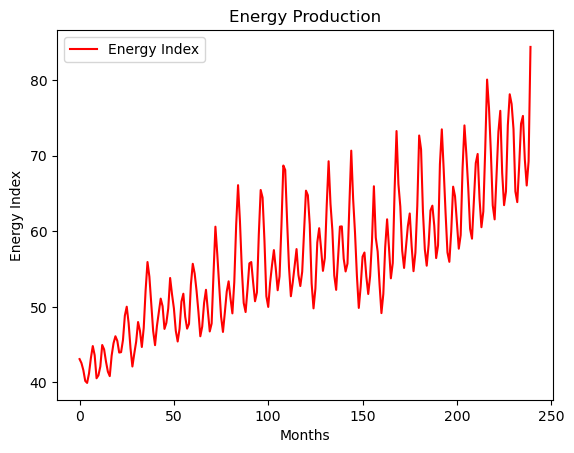

In [2]:
# Plot dataset
x = range(len(energy))
plt.plot(x, energy, 'r-', label='Energy Index')
plt.title('Energy Production')
plt.xlabel('Months')
plt.ylabel('Energy Index')
plt.legend()
plt.show()


### Naive Model

For comparison purposes, create output corresponding to a naive model that predicts that the energy production next month will be the same as the energy production this month. Compare this to the correct data by plotting the values side by side.

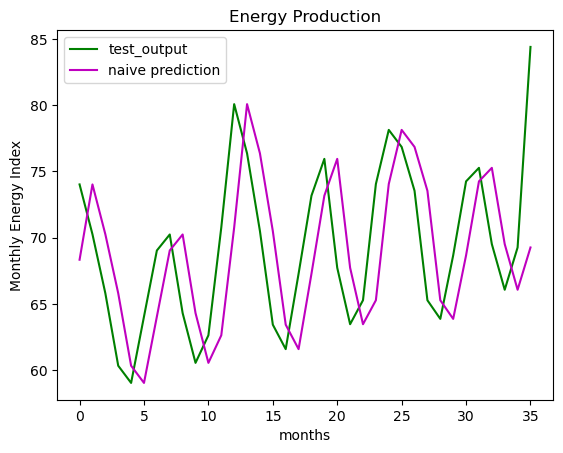

In [3]:
# Plot naive prediction
test_output = test_energy[MIN:]
naive_prediction = test_energy[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Energy Production')
plt.xlabel('months')
plt.ylabel('Monthly Energy Index')
plt.legend()
plt.show()


### Preprocessing the Data

In [4]:
# Standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_energy)
stddev = np.std(train_energy)
train_energy_std = (train_energy - mean)/stddev
test_energy_std = (test_energy - mean)/stddev

The code snippet below allocates tensors for the training data and initializes all entries to 0. It then loops through the historical data and creates training examples, then does the same thing with the test data.

In [5]:
# Create training examples.
train_months = len(train_energy)
train_X = np.zeros((train_months-MIN, train_months-1, 1))
train_y = np.zeros((train_months-MIN, 1))
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_energy_std[0:i+MIN]
    train_y[i, 0] = train_energy_std[i+MIN]

# Create test examples.
test_months = len(test_energy)
test_X = np.zeros((test_months-MIN, test_months-1, 1))
test_y = np.zeros((test_months-MIN, 1))
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_energy_std[0:i+MIN]
    test_y[i, 0] = test_energy_std[i+MIN]

In [23]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(180, 191, 1) (180, 1)
(36, 47, 1) (36, 1)


180 training samples and 36 testing samples (80%-20% split)

### Creating the RNN

In [36]:
# Create RNN model
model = Sequential()
model.add(SimpleRNN(128, activation='relu',
                    input_shape=(None, 1), return_sequences=True))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam',
              metrics =['mean_absolute_error'])
model.summary()
history = model.fit(train_X, train_y,
                    validation_data
                    = (test_X, test_y), epochs=EPOCHS,
                    batch_size=BATCH_SIZE, verbose=2,
                    shuffle=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, None, 128)         16640     
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 - 2s - loss: 0.5150 - mean_absolute_error: 0.5351 - val_loss: 0.7686 - val_mean_absolute_error: 0.6620 - 2s/epoch - 196ms/step
Epoch 2/100
12/12 - 1s - loss: 0.2086 - mean_absolute_error: 0.3423 - val_loss: 0.1794 - val_mean_absolute_error: 0.2894 - 682ms/epoch - 57ms/step
Epoch 3/100
12/12 - 1s

Epoch 51/100
12/12 - 1s - loss: 0.0065 - mean_absolute_error: 0.0626 - val_loss: 0.1051 - val_mean_absolute_error: 0.2217 - 623ms/epoch - 52ms/step
Epoch 52/100
12/12 - 1s - loss: 0.0056 - mean_absolute_error: 0.0576 - val_loss: 0.0985 - val_mean_absolute_error: 0.2073 - 641ms/epoch - 53ms/step
Epoch 53/100
12/12 - 1s - loss: 0.0040 - mean_absolute_error: 0.0501 - val_loss: 0.0984 - val_mean_absolute_error: 0.2195 - 635ms/epoch - 53ms/step
Epoch 54/100
12/12 - 1s - loss: 0.0038 - mean_absolute_error: 0.0490 - val_loss: 0.1063 - val_mean_absolute_error: 0.2320 - 622ms/epoch - 52ms/step
Epoch 55/100
12/12 - 1s - loss: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0849 - val_mean_absolute_error: 0.1981 - 620ms/epoch - 52ms/step
Epoch 56/100
12/12 - 1s - loss: 0.0070 - mean_absolute_error: 0.0670 - val_loss: 0.0855 - val_mean_absolute_error: 0.1965 - 615ms/epoch - 51ms/step
Epoch 57/100
12/12 - 1s - loss: 0.0071 - mean_absolute_error: 0.0661 - val_loss: 0.1239 - val_mean_absolute_erro

In [37]:
# Create naive prediction based on standardized data.
test_output = test_energy_std[MIN:]
naive_prediction = test_energy_std[MIN-1:-1] * stddev + mean
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)


naive test mse:  4474.2305
naive test mean abs:  66.69882


1/1 [==============================] - 0s 189ms/step
test mse:  4468.108
test mean abs:  66.69037


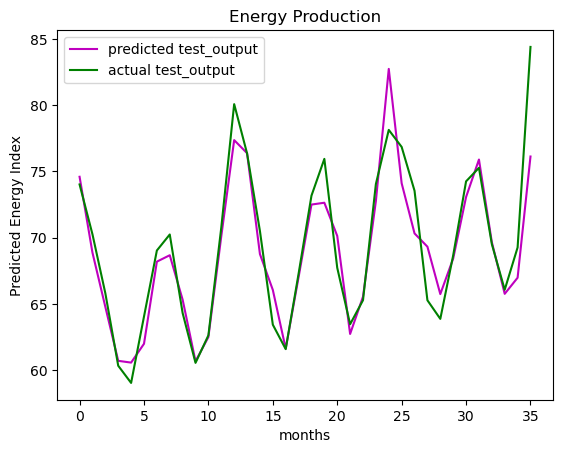

In [38]:
# Use trained model to predict the test data
predicted_test = model.predict(test_X, len(test_X))
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

mean_squared_error = np.mean(np.square(predicted_test
                                       - test_output))
mean_abs_error = np.mean(np.abs(predicted_test
                                - test_output))
print('test mse: ', mean_squared_error)
print('test mean abs: ', mean_abs_error)

# Plot test prediction.
x = range(len(test_energy)-MIN)
plt.plot(x, predicted_test, 'm-',
         label='predicted test_output')
plt.plot(x, test_energy[-(len(test_energy)-MIN):],
         'g-', label='actual test_output')
plt.title('Energy Production')
plt.xlabel('months')
plt.ylabel('Predicted Energy Index')
plt.legend()
plt.show()